<a href="https://colab.research.google.com/github/nhatvnguyen/spokane-power-forecast/blob/main/CAISO_Power_Demand_ForeCast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


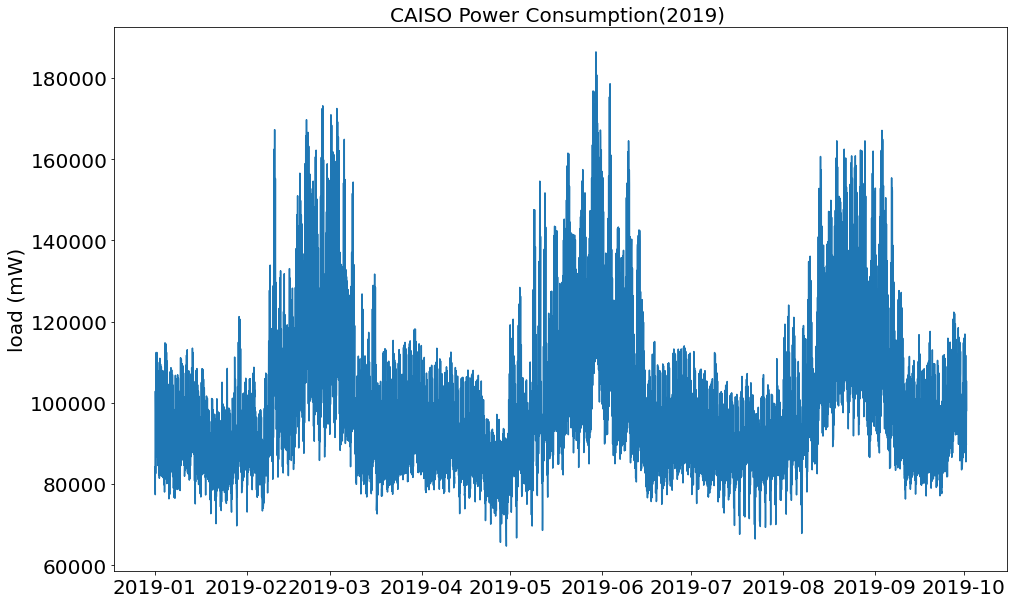

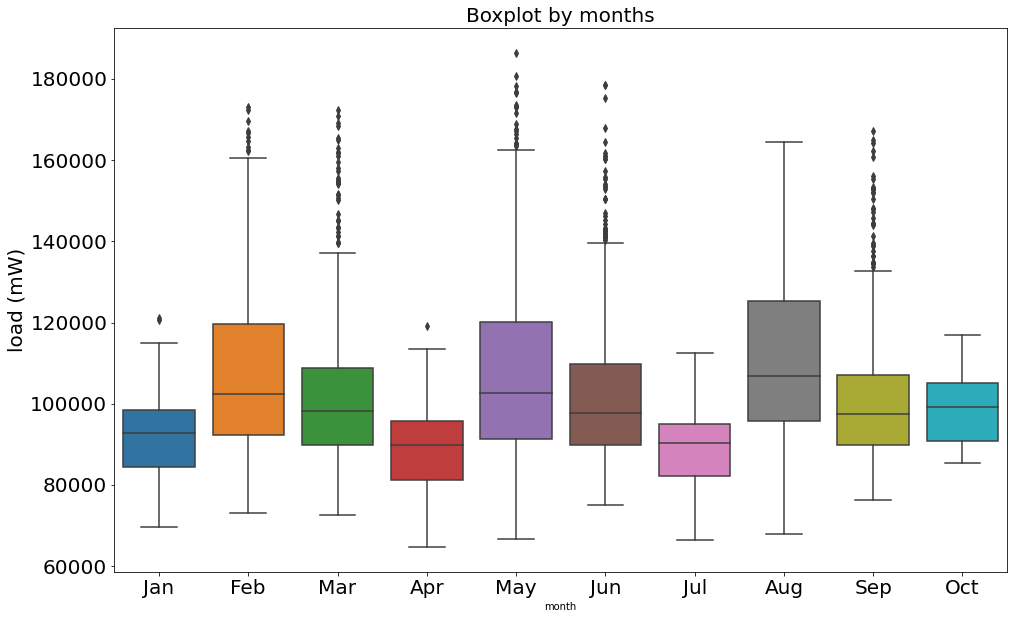

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 120)           58560     
                                                                 
 lstm_1 (LSTM)               (None, 24, 80)            64320     
                                                                 
 lstm_2 (LSTM)               (None, 40)                19360     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 142,281
Trainable params: 142,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
20/20 [==============================] - 8s 117ms/step - loss: 0.8903 - val_loss: 1.2816
Epoch 2/50
20/20 [==============================] - 1s 53ms/step - loss: 0.8282 - 

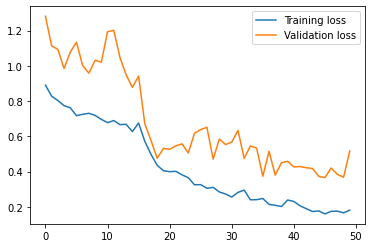

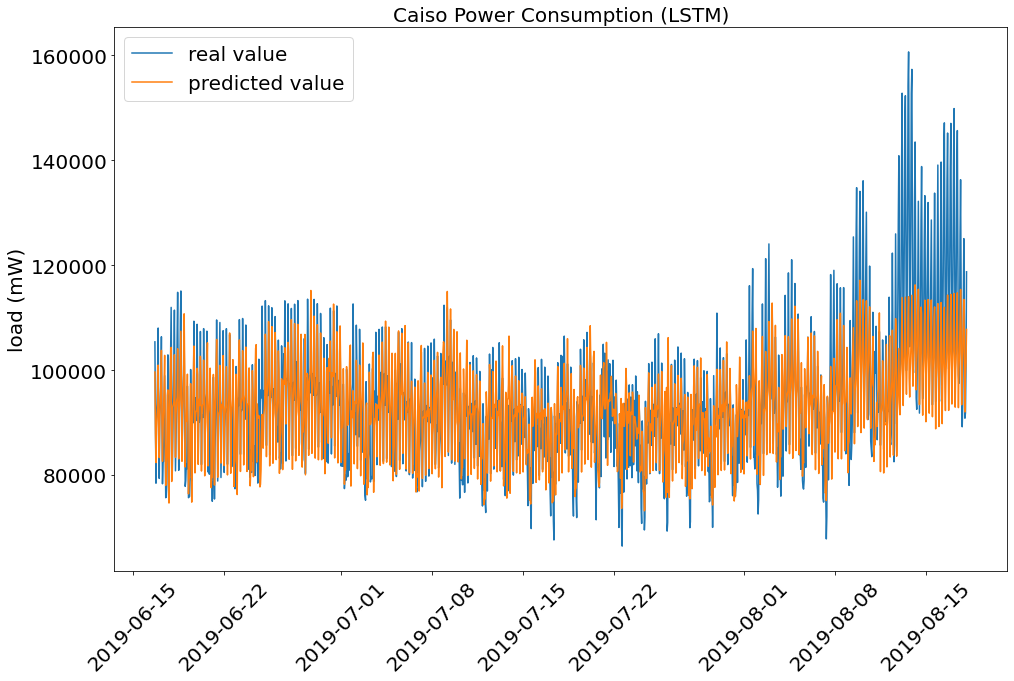

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               6400      
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [===========================

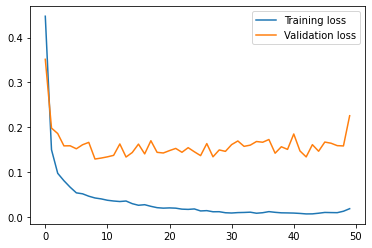

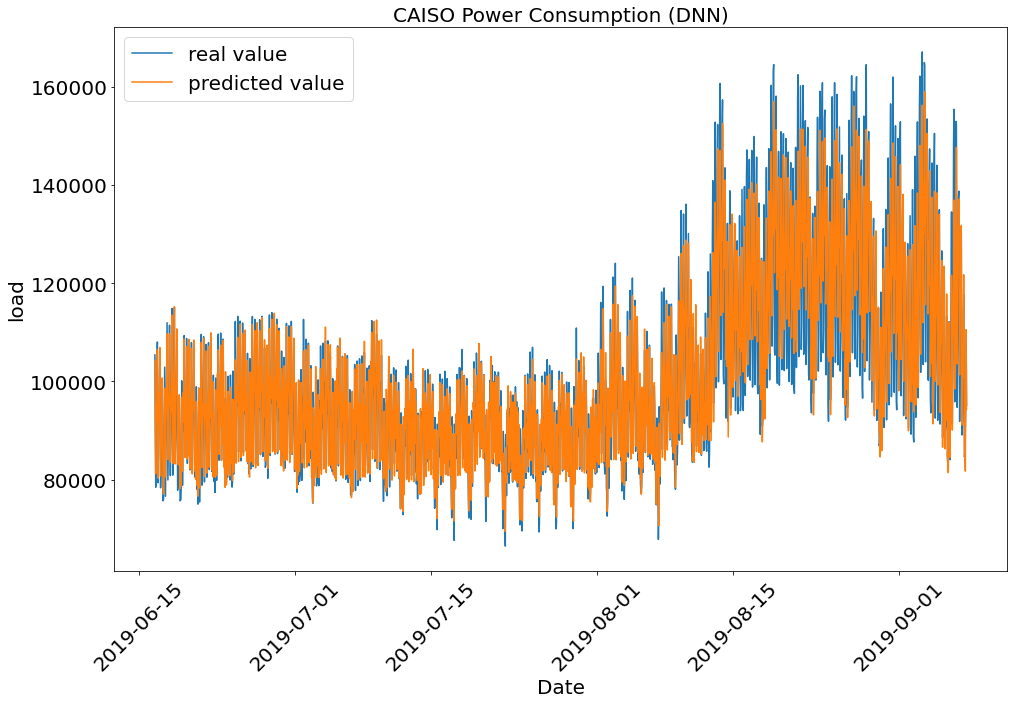

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/FinalProject/DatasetCaiso.csv /content

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
from sklearn.metrics import mean_squared_error


#data = pd.read_csv(r'S:\EENG496\HistoricalEMSHourlyLoad-2021 (1).csv')
data = pd.read_csv('DatasetCaiso.csv')

data_de = data.drop(['end'],axis=1)

train_set = data_de.loc[data_de['start'] <= '2019-01-31 00:00']
train_set = train_set.set_index("start")
train_set.index = pd.to_datetime(train_set.index)
train_set = train_set.groupby(pd.Grouper(freq="h")).sum()

test_set  = data_de.loc[data_de['start'] > '2019-01-31 00:00']
test_set = test_set.set_index("start")
test_set.index = pd.to_datetime(test_set.index)
test_set = test_set.groupby(pd.Grouper(freq="h")).sum()

data_de = data[['start', 'load']]
data_de['start'] = pd.to_datetime(data_de['start'])
data_de = data_de.set_index("start")
data_de = data_de.groupby(pd.Grouper(freq="h")).sum()

data_de['start'] = pd.to_datetime(data_de.index)

plt.figure(figsize=(16,10))
plt.plot(data_de['start'], data_de['load'])
plt.ylabel("load (mW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('CAISO Power Consumption(2019) ',fontsize=20)

#%% Boxplots
"""[2]"""
df = data_de.set_index("start")
df.index = pd.to_datetime(df.index)

df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime("%b") for d in df.index]


plt.figure(figsize=(16,10))
sns.boxplot(x='month', y='load', data=df)
plt.ylabel("load (mW)", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Boxplot by months',fontsize=20)
plt.show()

#%%scaling, train_test_split
"""[3]"""
scaler=StandardScaler()
scaler = scaler.fit(train_set[['load']])

train_set['load'] = scaler.transform(train_set[['load']])
test_set['load'] = scaler.transform(test_set[['load']])

last_n = 24

def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []
    for i in range(len(x)-last_n):
        x_values.append(x.iloc[i:(i+last_n)].values)
        y_values.append(y.iloc[i+last_n])
    return np.array(x_values), np.array(y_values)

x_train, y_train = to_sequences(train_set[['load']], train_set['load'], last_n)
x_test, y_test = to_sequences(test_set[['load']], test_set['load'], last_n)

#%%LSTM Model
model=Sequential()
model.add(LSTM(120,return_sequences=True,input_shape=(last_n,1)))
model.add(LSTM(80,return_sequences=True))
model.add(LSTM(40))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#%%Predictions (LSTM)
train_predict = model.predict(x_train)
test_predict  = model.predict(x_test)

predict_train = scaler.inverse_transform(train_predict)
predict_test  = scaler.inverse_transform(test_predict)

#%%Visualization of predictions(test_set)
previous_days = last_n

testPredictPlot = np.empty_like(df['load'])
testPredictPlot[:] = np.nan
testPredictPlot = testPredictPlot.reshape(-1,1)
testPredictPlot[len(train_predict)+(previous_days*2):len(df), :] = predict_test

df_tpp = pd.DataFrame(data=testPredictPlot, columns=['load'])
df_tpp['start'] = df.index
df_tpp['start'] = pd.to_datetime(df_tpp['start'])
df_tpp = df_tpp.set_index("start")

df_predict = df['load']

plt.figure(figsize=(16,10))
plt.plot(df_predict[4000:5500],label='real value')
plt.xticks(rotation=45)
plt.ylabel("load (mW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Caiso Power Consumption (LSTM)',fontsize=20)
plt.plot(df_tpp[4000:5500],label='predicted value')
plt.xticks(rotation=45)
plt.legend(fontsize=20)
plt.show()

#%% Deep Neural Network Model
""" [4] """
x_train_dnn = x_train.reshape(len(x_train),last_n)
x_test_dnn = x_test.reshape(len(x_test),last_n)

dnn_model =  Sequential()
dnn_model.add(Dense(256, input_dim=last_n, activation='relu'))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(1))
dnn_model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])

print(dnn_model.summary())

dnn_history = dnn_model.fit(x_train_dnn, y_train, epochs=50, batch_size=32, validation_split=0.1)

plt.plot(dnn_history.history['loss'], label='Training loss')
plt.plot(dnn_history.history['val_loss'], label='Validation loss')
plt.legend()

#%%
dnn_trainpredict = dnn_model.predict(x_train_dnn)
dnn_testpredict = dnn_model.predict(x_test_dnn)

dnn_train_predict = scaler.inverse_transform(dnn_trainpredict)
y_train_inverse = scaler.inverse_transform([y_train])
dnn_test_predict = scaler.inverse_transform(dnn_testpredict)
y_test_inverse = scaler.inverse_transform([y_test])


#%%
dnn_testPredictPlot = np.empty_like(df['load'])
dnn_testPredictPlot[:] = np.nan
dnn_testPredictPlot = dnn_testPredictPlot.reshape(-1,1)
dnn_testPredictPlot[len(train_predict)+(previous_days*2):len(df), :] = dnn_test_predict

df_dnn_tpp = pd.DataFrame(data=dnn_testPredictPlot, columns=['load'])
df_dnn_tpp['start'] = df.index
df_dnn_tpp['start'] = pd.to_datetime(df_dnn_tpp['start'])
df_dnn_tpp = df_dnn_tpp.set_index("start")

plt.figure(figsize=(16,10))
plt.plot(df_predict[4000:6000],label='real value')
plt.xlabel("Date", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("load", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('CAISO Power Consumption (DNN)',fontsize=20)
plt.plot(df_dnn_tpp[4000:6000],label='predicted value')
plt.xticks(rotation=45)
plt.legend(fontsize=20)
plt.show()